#### Importing libs and instanciating SC and SQLSC

In [157]:
# useful libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# pyspark libs
from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession, Row, Window
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.mllib.feature import StandardScaler, Normalizer, HashingTF, IDF
from pyspark.mllib.linalg import Vectors, SparseVector, DenseMatrix
from pyspark.mllib.stat import Statistics

# classification libs
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, GBTClassifier, MultilayerPerceptronClassifier, DecisionTreeClassificationModel, RandomForestClassificationModel
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from pyspark.ml.feature import StringIndexer, VectorIndexer, Imputer, MinMaxScaler, VectorAssembler, OneHotEncoder, QuantileDiscretizer, Bucketizer
from pyspark.ml.stat import Correlation

#### Loading the dataframe

In [2]:
ss = SparkSession.builder.appName("classification_final").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/15 12:39:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Read the CSV file with multiline values (description and facilities)
data = ss.read.options(header = True, inferSchema = True, multiline = True, escape = "\"").csv("dataframe_totalCleaned.csv")

# dataframe's dimension and attributes
print(f"Size of the dataframe:\n{data.count(), len(data.columns)}")
print()
print(f"Columns names:\n{data.columns}")
print()
print(f"Columns and types:\n{data.dtypes}")

Size of the dataframe:
(188417, 27)

Columns names:
['regio1', 'heatingType', 'balcony', 'firingTypes', 'hasKitchen', 'cellar', 'condition', 'interiorQual', 'petsAllowed', 'streetPlain', 'lift', 'typeOfFlat', 'geo_plz', 'garden', 'regio2', 'regio3', 'description', 'facilities', 'log_pictureCount', 'log_yearConstructed', 'log_noRooms', 'log_floor', 'log_numberOfFloors', 'log_serviceCharge', 'log_baseRent', 'log_livingSpace', 'log_thermalChar']

Columns and types:
[('regio1', 'string'), ('heatingType', 'string'), ('balcony', 'boolean'), ('firingTypes', 'string'), ('hasKitchen', 'boolean'), ('cellar', 'boolean'), ('condition', 'string'), ('interiorQual', 'string'), ('petsAllowed', 'string'), ('streetPlain', 'string'), ('lift', 'boolean'), ('typeOfFlat', 'string'), ('geo_plz', 'int'), ('garden', 'boolean'), ('regio2', 'string'), ('regio3', 'string'), ('description', 'string'), ('facilities', 'string'), ('log_pictureCount', 'double'), ('log_yearConstructed', 'double'), ('log_noRooms', 'doub

In [4]:
# dropping geo_plz (found high correlation with regio1) and streetPlain (the info about the address of the apartment is too specific)
data = data.drop("geo_plz", "streetPlain")

In [5]:
print(f"Size of the dataframe: {data.count(), len(data.columns)}")

Size of the dataframe: (188417, 25)


### Defining classification's target variable and number of classes

In [6]:
target = "log_livingSpace"

if data.select(target).dtypes[0][1] == "double":
    # how many classes if we have to discretize the target
    n_classes = 3
else:
    n_classes = data.select(target).distinct().count()

print(f"Number of classes: {n_classes}")

Number of classes: 3


### Classification pre-processing

In [7]:
def atts_by_type(dataframe, target):
    textAtts = ["description", "facilities"]
    contAtts = [c[0] for c in dataframe.dtypes if (c[1] == "double") and (c[0] != target)]
    catAtts = [c[0] for c in dataframe.dtypes if ((c[1] == "string") and (c[0] not in textAtts)) and (c[0] != target)]
    boolAtts = [c for c in dataframe.columns if c not in (contAtts + catAtts + textAtts) and (c != target)]
    
    # show the attributes of different types
    print(f"Free text attributes:\n{textAtts}", end = "\n\n")
    print(f"Numerical attributes:\n{contAtts}", end = "\n\n")
    print(f"Categorical attributes:\n{catAtts}", end = "\n\n")
    print(f"Boolean attributes:\n{boolAtts}", end = "\n\n")
    
    # return double, string and boolean attributes as lists in this order
    return textAtts, contAtts, catAtts, boolAtts

In [8]:
textAtts, contAtts, catAtts, boolAtts = atts_by_type(data, target)

Free text attributes:
['description', 'facilities']

Numerical attributes:
['log_pictureCount', 'log_yearConstructed', 'log_noRooms', 'log_floor', 'log_numberOfFloors', 'log_serviceCharge', 'log_baseRent', 'log_thermalChar']

Categorical attributes:
['regio1', 'heatingType', 'firingTypes', 'condition', 'interiorQual', 'petsAllowed', 'typeOfFlat', 'regio2', 'regio3']

Boolean attributes:
['balcony', 'hasKitchen', 'cellar', 'lift', 'garden']



### Shuffling and global transformations

In [9]:
# shuffling the rows to remove any ordering bias
shuff_data = data.orderBy(F.rand(seed = 42))

#### One-Hot-Encoding and StringIndexing independent features

In [48]:
data_encoded = shuff_data.select("*")

##### Decided to dummify with OneHotEncoder only categoricals with less than 10 distinct values and keep the others only indexed through StringIndexer and then scaling these last to make them aligned with the 0-1 range of the other numerical features
This was done to ensure we didn't create thousands of columns (since dummifying means adding a binary column for each distinct value of each attribute)

In [12]:
oneHotAtts = []
strIdxAtts = []

for att in catAtts:
    dist = data_encoded.select(att).distinct().count()
    if dist > 10:
        strIdxAtts.append(att)
    else:
        oneHotAtts.append(att)

In [49]:
# printing both lists
print(f"Attributes for OneHotEncoder:\n{oneHotAtts}\n")
print(f"Attributes for only StringIndexer:\n{strIdxAtts}")

Attributes for OneHotEncoder:
['condition', 'interiorQual', 'petsAllowed', 'typeOfFlat']

Attributes for only StringIndexer:
['regio1', 'heatingType', 'firingTypes', 'regio2', 'regio3']


In [50]:
for att in catAtts:
    # index categorical column using StringIndexer
    indexer = StringIndexer(inputCol = att, outputCol = f"{att}_index")
    data_encoded = indexer.fit(data_encoded).transform(data_encoded)
    
    # drop non indexed attribute
    data_encoded = data_encoded.drop(att)
    
    if att in oneHotAtts:
        encoder = OneHotEncoder(inputCol = f"{att}_index", outputCol = f"{att}_encoded")
        data_encoded = encoder.fit(data_encoded).transform(data_encoded)
    
        # dropping the indexed and original attributes, since we have the encoded version
        data_encoded = data_encoded.drop(f"{att}_index")
        data_encoded = data_encoded.drop(att)
        
        # renaming the encoded columns as originals
        data_encoded = data_encoded.withColumnRenamed(f"{att}_encoded", att)

In [51]:
print(f"Attributes:\n{data_encoded.columns}")

Attributes:
['balcony', 'hasKitchen', 'cellar', 'lift', 'garden', 'description', 'facilities', 'log_pictureCount', 'log_yearConstructed', 'log_noRooms', 'log_floor', 'log_numberOfFloors', 'log_serviceCharge', 'log_baseRent', 'log_livingSpace', 'log_thermalChar', 'regio1_index', 'heatingType_index', 'firingTypes_index', 'condition', 'interiorQual', 'petsAllowed', 'typeOfFlat', 'regio2_index', 'regio3_index']


In [53]:
# show encoded attributes
data_encoded.select("regio1_index").limit(5).show()
data_encoded.select("petsAllowed").limit(5).show()

+------------+
|regio1_index|
+------------+
|         5.0|
|         7.0|
|         0.0|
|         3.0|
|         6.0|
+------------+



+-------------+
|  petsAllowed|
+-------------+
|(2,[0],[1.0])|
|(2,[0],[1.0])|
|(2,[0],[1.0])|
|(2,[1],[1.0])|
|(2,[1],[1.0])|
+-------------+



### Train-Test split and scaling

In [70]:
# split into training and testing sets before scaling
df_train_bs, df_test_bs = data_encoded.randomSplit([0.7, 0.3], seed = 42)
#print(f"Size of df_train_bs (not assembled): {df_train_bs.count(), len(df_train_bs.columns)}")
#print(f"Size of df_test_bs (not assembled): {df_test_bs.count(), len(df_test_bs.columns)}")

#### MinMax Scaler
Fit on df_train, apply to df_test -> avoid Data Leakage

In [71]:
df_train_scaled = df_train_bs.select("*")
df_test_scaled = df_test_bs.select("*")

In [72]:
for att in strIdxAtts:
    assembler_temp = VectorAssembler(inputCols=[f"{att}_index"], outputCol=f"{att}_temp")

    # assemble the feature for scaling in the training set
    df_train_scaled = assembler_temp.transform(df_train_scaled)

    # drop indexed since using assembled feature
    df_train_scaled = df_train_scaled.drop(f"{att}_index")

    # scaler
    scaler = MinMaxScaler(inputCol=f"{att}_temp", outputCol=f"{att}_scaled")
    scaler_model = scaler.fit(df_train_scaled)
    df_train_scaled = scaler_model.transform(df_train_scaled)

    # drop temp feature
    df_train_scaled = df_train_scaled.drop(f"{att}_temp")

    # apply the same scaler to the test set
    df_test_scaled = assembler_temp.transform(df_test_scaled)
    df_test_scaled = df_test_scaled.drop(f"{att}_index")
    df_test_scaled = scaler_model.transform(df_test_scaled)
    df_test_scaled = df_test_scaled.drop(f"{att}_temp")

In [76]:
print(f"Size of the scaled df_train: {df_train_scaled.count(), len(df_train_scaled.columns)}\n")
print(f"Size of the scaled df_test: {df_test_scaled.count(), len(df_test_scaled.columns)}")

Size of the scaled df_train: (131978, 25)



Size of the scaled df_test: (56444, 25)


##### Renaming attributes

In [77]:
for att in strIdxAtts:
    df_train_scaled = df_train_scaled.withColumnRenamed(f"{att}_scaled", att)
    df_test_scaled = df_test_scaled.withColumnRenamed(f"{att}_scaled", att)

In [78]:
print(f"Attributes in the scaled df_train:\n{df_train_scaled.columns}\n")
print(f"Attributes in the scaled df_test:\n{df_test_scaled.columns}")

Attributes in the scaled df_train:
['balcony', 'hasKitchen', 'cellar', 'lift', 'garden', 'description', 'facilities', 'log_pictureCount', 'log_yearConstructed', 'log_noRooms', 'log_floor', 'log_numberOfFloors', 'log_serviceCharge', 'log_baseRent', 'log_livingSpace', 'log_thermalChar', 'condition', 'interiorQual', 'petsAllowed', 'typeOfFlat', 'regio1', 'heatingType', 'firingTypes', 'regio2', 'regio3']

Attributes in the scaled df_test:
['balcony', 'hasKitchen', 'cellar', 'lift', 'garden', 'description', 'facilities', 'log_pictureCount', 'log_yearConstructed', 'log_noRooms', 'log_floor', 'log_numberOfFloors', 'log_serviceCharge', 'log_baseRent', 'log_livingSpace', 'log_thermalChar', 'condition', 'interiorQual', 'petsAllowed', 'typeOfFlat', 'regio1', 'heatingType', 'firingTypes', 'regio2', 'regio3']


In [80]:
# checking scaled in train and test
print("Attribute in df_train_scaled")
df_train_scaled.select("regio1").limit(5).show()
print("Attribute in df_test_scaled")
df_test_scaled.select("regio1").limit(5).show()

Attribute in df_train_scaled


+--------------------+
|              regio1|
+--------------------+
|               [0.4]|
|               [0.8]|
|[0.06666666666666...|
|               [0.8]|
|               [0.8]|
+--------------------+

Attribute in df_test_scaled


+--------------------+
|              regio1|
+--------------------+
|               [0.0]|
|[0.06666666666666...|
|[0.13333333333333...|
|[0.06666666666666...|
|               [0.4]|
+--------------------+



##### Dummifying booleans

In [81]:
# dummifying booleans
for att in boolAtts:
    df_train_scaled = df_train_scaled.withColumn(att, F.col(att).cast(IntegerType()))
    df_test_scaled = df_test_scaled.withColumn(att, F.col(att).cast(IntegerType()))

In [83]:
# checking encoded, scaled and bools attributes after the transformations
df_train_scaled.select("firingTypes").limit(5).show()
df_train_scaled.select("hasKitchen").limit(5).show()
df_train_scaled.select("regio1").limit(5).show()

+--------------------+
|         firingTypes|
+--------------------+
|[0.00840336134453...|
|               [0.0]|
|[0.00840336134453...|
|               [0.0]|
|               [0.0]|
+--------------------+



+----------+
|hasKitchen|
+----------+
|         0|
|         0|
|         0|
|         0|
|         0|
+----------+



+--------------------+
|              regio1|
+--------------------+
|               [0.8]|
|               [0.0]|
|               [0.8]|
|               [0.8]|
|[0.06666666666666...|
+--------------------+



##### Not keeping free text attributes

In [89]:
# copying the encoded df_train and df_test without the free text variables (we may treat them separately)
df_train_original = df_train_scaled.select(*[F.col(c) for c in df_train_scaled.columns if c not in textAtts])
df_test_original = df_test_scaled.select(*[F.col(c) for c in df_test_scaled.columns if c not in textAtts])

In [90]:
# combining all features into a single vector column
features = [c for c in df_train_original.columns if c != target]

assembler = VectorAssembler(inputCols = features, outputCol="features")
df_train, df_test = assembler.transform(df_train_original), assembler.transform(df_test_original)

In [91]:
# only target and assembled features
df_train, df_test = df_train.select(target, "features"), df_test.select(target, "features")

print(f"Size of df_train: {df_train.count(), len(df_train.columns)}")
print(f"Size of df_test: {df_test.count(), len(df_test.columns)}")

Size of df_train: (131980, 2)


Size of df_test: (56401, 2)


### Discretization of the target variable (if needed)

In [92]:
df_train.select(target).dtypes

[('log_livingSpace', 'double')]

##### Natural binning

In [93]:
def target_for_class(df_train, df_test, target, nBins):
    target_label = target + "_label"
    
    if df_train.select(target).dtypes[0][1] == "double":
        nBins = nBins
        
        # instanciating QuantileDiscretizer
        discretizer = QuantileDiscretizer(numBuckets = nBins, inputCol = target, outputCol = target_label)
        
        # fit on the training set
        discretizer_model = discretizer.fit(df_train)
        df_train_discr = discretizer_model.transform(df_train)

        # transform the test set using the same discretizer
        df_test_discr = discretizer_model.transform(df_test)
        
    elif df_train.select(target).dtypes[0][1] == "string":
        # stringIndexing the label if string
        label_indexer = StringIndexer(inputCol = target, outputCol = target_label)
        
        label_indexer_model = label_indexer.fit(df_train)
        df_train_discr = label_indexer_model.transform(df_train)
        
        df_test_discr = label_indexer_model.transform(df_test)
        
    else:
        df_train_discr = df_train.select("*")
        df_test_discr = df_test.select("*")
    
    # select only label and features
    df_train_discr = df_train_discr.select(target_label, "features")
    df_test_discr = df_test_discr.select(target_label, "features")
    
    # return the df and the target_label
    return df_train_discr, df_test_discr, target_label

In [94]:
df_train, df_test, target_label = target_for_class(df_train, df_test, target, n_classes)

In [95]:
# checking the resulting discretized data
print(df_train.columns)
print(df_test.columns)
df_train.select(target_label, "features").limit(2).show()
df_test.select(target_label, "features").limit(2).show()

['log_livingSpace_label', 'features']
['log_livingSpace_label', 'features']


+---------------------+--------------------+
|log_livingSpace_label|            features|
+---------------------+--------------------+
|                  0.0|(41,[5,6,8,9,10,1...|
|                  0.0|(41,[5,6,7,8,9,10...|
+---------------------+--------------------+



+---------------------+--------------------+
|log_livingSpace_label|            features|
+---------------------+--------------------+
|                  0.0|(41,[5,6,8,9,10,1...|
|                  0.0|(41,[5,6,8,9,10,1...|
+---------------------+--------------------+



##### Equal width binning (2 bins with only 2 values... not good)

## Classification

#### Rebalancing the classes for FS (only using training set)

In [101]:
# percentage of rows for each class for evaluating the model (not on df_test), minority and majority classes
maj_fract = 0.4
min_fract = 0.4

In [102]:
# stratified sampling the df based on the classes
fractions = {i:min_fract for i in range(1, n_classes)}
fractions[0] = maj_fract
print(f"Fractions for each class: {fractions}")

sampled_dataframe = df_train.sampleBy(target_label, fractions = fractions, seed = 42)
print(f"Size of the sampled df: {sampled_dataframe.count(), len(sampled_dataframe.columns)}")

Fractions for each class: {1: 0.4, 2: 0.4, 0: 0.4}


Size of the sampled df: (52738, 2)


##### Tr-Val split (FS purposes)

In [103]:
# split the training into tr and validation sets
df_tr, df_val = sampled_dataframe.randomSplit([0.7, 0.3], seed = 42)
print(f"Size of df_tr for feature selection: {df_tr.count(), len(df_tr.columns)}")
#print(f"Size of df_val for feature selection: {df_val.count(), len(df_val.columns)}")

Size of df_tr for feature selection: (36948, 2)


### DT feature importances
Using a sample of the data

In [154]:
def fit_eval_classif(df_train, df_valOrTest, classifier, target_label):
    model_name = classifier.uid.split("_")[0]
    print(f"Model: {model_name}")
    # Train the model
    model = classifier.fit(df_tr)
    
    # Make predictions on the testing data
    predictions = model.transform(df_val)
    
    # define metrics on which to evaluate the model
    metrics = ["accuracy", "weightedPrecision", "weightedRecall", "weightedFMeasure"]
    
    # dict of all evaluations based on the metrics
    evaluations = {}
    
    # evaluations
    for m in metrics:
        evaluator = MulticlassClassificationEvaluator(labelCol = target_label, predictionCol = "prediction", metricName = m)
        evaluations[m] = evaluator.evaluate(predictions)
        
    # feature importance (dt and rf only)
    feature_importance = None
    # check if dt or rf
    if isinstance(model, (DecisionTreeClassificationModel, RandomForestClassificationModel)):
        feature_importance = model.featureImportances
    
    # uid to extract the name of the model
    print(f"Evaluation:")
    
    # show the metrics
    for m in evaluations:
        print(f"{m}:\n{round(evaluations[m],3)}\n")
    
    print("------------------------------------------------------")
    print("------------------------------------------------------")
    
    return model, evaluations, predictions, feature_importance

In [105]:
# decision tree
dt_fs = DecisionTreeClassifier(labelCol = target_label, featuresCol = "features", maxDepth = 10, seed = 42)

In [155]:
# model and evaluation
#mod, ev, pred, fi = fit_eval_classif(df_tr, df_val, dt_fs, target_label)

    Evaluation:
    accuracy:
    0.756

    weightedPrecision:
    0.761

    weightedRecall:
    0.75

    weightedFMeasure:
    0.759

In [108]:
# Get feature importances
feature_importances = mod.featureImportances

# Get the input feature names from the VectorAssembler
input_feature_names = assembler.getInputCols()

# Create a list of tuples containing feature names and their importances
features_with_importance = list(zip(input_feature_names, feature_importances))

# Print the feature importances
print("Feature Importances:")
for feature, importance in features_with_importance:
    print(f"{feature}: {importance}")

Feature Importances:
balcony: 0.0024951281979189287
hasKitchen: 0.004661777928616692
cellar: 0.0008117348068032434
lift: 0.0024183336595379537
garden: 0.0012397392702751234
log_pictureCount: 0.007990303821889935
log_yearConstructed: 0.02505479242239799
log_noRooms: 0.41180665513677706
log_floor: 0.0036979846125257568
log_numberOfFloors: 0.005192584594828923
log_serviceCharge: 0.1190900368570473
log_baseRent: 0.3434121082996723
log_thermalChar: 0.007139299823465083
condition: 0.0018058674512331143
interiorQual: 0.001109127508857069
petsAllowed: 0.00017360461138474963
typeOfFlat: 0.0
regio1: 0.000556928759678516
heatingType: 0.0006036617974549091
firingTypes: 0.0016691338035828421
regio2: 0.00013700375042712654
regio3: 0.00024940237857070817


### Selecting Features

In [119]:
# selecting important features
important_atts = [att for att, importance in features_with_importance if importance >= 0.002]
print(f"Number of selected features: {len(important_atts)}\nNumber of original features: {len(df_train_original.columns)}\n")
print(f"Selected features:\n{important_atts}")

# indexes of important features
selected_indexes = [df_train_original.columns.index(att) for att in important_atts]
print("Indexes:", selected_indexes)

# creating dataframe with important features
#df_tuning = df.select(target, *important_atts)
#df_tuning.columns

Number of selected features: 11
Number of original features: 23

Selected features:
['balcony', 'hasKitchen', 'lift', 'log_pictureCount', 'log_yearConstructed', 'log_noRooms', 'log_floor', 'log_numberOfFloors', 'log_serviceCharge', 'log_baseRent', 'log_thermalChar']
Indexes: [0, 1, 3, 5, 6, 7, 8, 9, 10, 11, 13]


In [124]:
# combining all features into a single vector column
features = [c for c in df_train_original.columns if (c != target) and (c in important_atts)]

assembler = VectorAssembler(inputCols = features, outputCol="features")
df_train, df_test = assembler.transform(df_train_original), assembler.transform(df_test_original)

In [125]:
# only target and assembled features
df_train, df_test = df_train.select(target, "features"), df_test.select(target, "features")

print(f"Size of df_train: {df_train.count(), len(df_train.columns)}")
print(f"Size of df_test: {df_test.count(), len(df_test.columns)}")

Size of df_train: (131939, 2)


Size of df_test: (56408, 2)


In [127]:
print(df_train.columns)
df_train.select(target, "features").limit(2).show()

['log_livingSpace', 'features']


+--------------------+--------------------+
|     log_livingSpace|            features|
+--------------------+--------------------+
| 0.02176149178151271|[0.0,0.0,0.0,0.00...|
|0.055860349496621886|[0.0,0.0,0.0,0.03...|
+--------------------+--------------------+



In [128]:
df_train, df_test, target_label = target_for_class(df_train, df_test, target, n_classes)

In [129]:
print(df_train.columns)
df_train.select(target_label, "features").limit(2).show()

['log_livingSpace_label', 'features']


+---------------------+--------------------+
|log_livingSpace_label|            features|
+---------------------+--------------------+
|                  0.0|[0.0,0.0,0.0,0.00...|
|                  0.0|[0.0,0.0,0.0,0.03...|
+---------------------+--------------------+



#### Sampling for tuning

In [130]:
# percentage of rows for each class for evaluating the model (not on df_test), minority and majority classes
maj_fract = 0.4
min_fract = 0.4

In [131]:
# stratified sampling the df based on the classes
fractions = {i:min_fract for i in range(1, n_classes)}
fractions[0] = maj_fract
print(f"Fractions for each class: {fractions}")

sampled_dataframe = df_train.sampleBy(target_label, fractions = fractions, seed = 42)
print(f"Size of the sampled training set: {sampled_dataframe.count(), len(sampled_dataframe.columns)}")

Fractions for each class: {1: 0.4, 2: 0.4, 0: 0.4}


Size of the sampled training set: (52717, 2)


#### Tr-Val split (Tuning purposes)

In [132]:
# split the training into tr and validation sets
df_tr, df_val = sampled_dataframe.randomSplit([0.7, 0.3], seed = 42)
print(f"Size of df_tr for tuning: {df_tr.count(), len(df_tr.columns)}")
#print(f"Size of df_val for feature selection: {df_val.count(), len(df_val.columns)}")

Size of df_tr for tuning: (36958, 2)


In [133]:
# number of features
num_input_features = len(df_tr.select("features").first()[0])
print(f"Number of features for tuning: {num_input_features}")

Number of features for tuning: 11


### Hyper-parameter tuning
#### This part is very time consuming, therefore only the best results are printed and the all the code is commented
On a stratified sample of the dataset

In [134]:
def tune_classif(df_tr, df_val, target_label, classifier, params):
    model_name = classifier.uid.split("_")[0]
    print(f"Model: {model_name}")
    # define Evaluator
    evaluator = MulticlassClassificationEvaluator(labelCol = target_label, predictionCol="prediction", metricName="weightedFMeasure")
    
    # CrossValidator
    cv = CrossValidator(estimator = classifier,
                        estimatorParamMaps = params,
                        evaluator = evaluator,
                        numFolds = 3,
                        seed = 42,
                        parallelism = 20)
    
    # cross validation
    cv_model = cv.fit(df_train)
    
    # get best model
    best_model = cv_model.bestModel
    
    # predictions using the best model
    predictions = best_model.transform(df_val)
    
    # evaluation with only weightedFmeasure
    weightedFMeasure = evaluator.evaluate(predictions)
    
    print(f"Best Model weightedFMeasure: {round(weightedFMeasure, 3)}")
    
    return best_model

#### Models to tune

In [135]:
dt = DecisionTreeClassifier(labelCol = target_label, featuresCol="features")
rf = RandomForestClassifier(labelCol = target_label, featuresCol="features")
nn = MultilayerPerceptronClassifier(labelCol = target_label, featuresCol="features")

classifiers = [dt, rf, nn]

#### Tuning - 3 classes

In [136]:
# DT
# min instances per node -> not 1 to minimize complexity
maxDepth = [20]# 10, 25, 20, 15, 5
minInstancesPerNode = [100]# 50, 100, 200, 300
seed = [42]
maxBins = [64]# 20, 32, 64, 96
minInfoGain = [0.01]# 0.02, 0.04, 0.1

# RF
maxDepth_rf = [20]# 5, 10, 15, 20, 30
maxBins_rf = [64]# 20, 32, 64, 96
featureSubsetStrategy = ["log2"]# "sqrt"
numTrees = [5]#5, 10, 15, 20, 30, 40

# NN
layers = [[num_input_features, 5 , n_classes]]
#[num_input_features, 14, n_classes],[num_input_features, 14, 10, n_classes],
#[num_input_features, 4, n_classes],[num_input_features, 10, n_classes]

blockSize = [128]# 256, 512
stepSize = [0.01]# 0.01, 0.05, 0.1
maxIter = [200]# 300, 100

# define parameter grids for each classifier
params_dt = ParamGridBuilder()\
            .addGrid(dt.maxDepth, maxDepth)\
            .addGrid(dt.minInstancesPerNode, minInstancesPerNode)\
            .addGrid(dt.seed, seed)\
            .addGrid(dt.maxBins, maxBins)\
            .addGrid(dt.minInfoGain, minInfoGain)\
            .build()

# using the params in common with the dt if possible (to speed up the process)
params_rf = ParamGridBuilder()\
            .addGrid(rf.maxDepth, maxDepth_rf)\
            .addGrid(rf.maxBins, maxBins_rf)\
            .addGrid(rf.minInstancesPerNode, minInstancesPerNode)\
            .addGrid(rf.minInfoGain, minInfoGain)\
            .addGrid(rf.seed, seed)\
            .addGrid(rf.featureSubsetStrategy, featureSubsetStrategy)\
            .addGrid(rf.numTrees, numTrees)\
            .build()


params_nn = ParamGridBuilder()\
            .addGrid(nn.layers, layers)\
            .addGrid(nn.blockSize, blockSize)\
            .addGrid(nn.stepSize, stepSize)\
            .addGrid(nn.seed, seed)\
            .addGrid(nn.maxIter, maxIter)\
            .build()

#### Decision Tree - tuning - 3 classes

##### Best model -> Best hyper params

In [137]:
#best_model_dt = tune_classif(df_tr, df_val, target_label, dt, params_dt)

In [138]:
#best_params_dt = best_model_dt.extractParamMap()
#print("Best Model Parameters:")
#for param, value in best_params_dt.items():
#    print(f"{param.name}: {value}")

#### DT results - 3 classes

Model: DecisionTreeClassifier

    Best Model weightedFMeasure: 0.747
    
    Best Model Parameters:
    cacheNodeIds: False
    checkpointInterval: 10
    featuresCol: features
    impurity: gini
    labelCol: log_livingSpace_label
    leafCol: 
    maxBins: 64
    maxDepth: 20
    maxMemoryInMB: 256
    minInfoGain: 0.01
    minInstancesPerNode: 100
    minWeightFractionPerNode: 0.0
    predictionCol: prediction
    probabilityCol: probability
    rawPredictionCol: rawPrediction
    seed: 42

#### Random Forest - tuning - 3 classes

##### Best model -> Best hyper params

In [139]:
#best_model_rf = tune_classif(df_tr, df_val, target_label, rf, params_rf)

In [140]:
#best_params_rf = best_model_rf.extractParamMap()
#print("Best Model Parameters:")
#for param, value in best_params_rf.items():
#    print(f"{param.name}: {value}")

#### RF results - 3 classes

Model: RandomForestClassifier

    Best Model weightedFMeasure: 0.73
    
    Best Model Parameters:
    bootstrap: True
    cacheNodeIds: False
    checkpointInterval: 10
    featureSubsetStrategy: log2
    featuresCol: features
    impurity: gini
    labelCol: log_livingSpace_label
    leafCol: 
    maxBins: 64
    maxDepth: 20
    maxMemoryInMB: 256
    minInfoGain: 0.01
    minInstancesPerNode: 100
    minWeightFractionPerNode: 0.0
    numTrees: 5
    predictionCol: prediction
    probabilityCol: probability
    rawPredictionCol: rawPrediction
    seed: 42
    subsamplingRate: 1.0

#### Neural Network - tuning - 3 classes

##### Best model -> Best hyper params

In [141]:
#best_model_nn = tune_classif(df_tr, df_val, target_label, nn, params_nn)

In [142]:
#best_params_nn = best_model_nn.extractParamMap()
#print("Best Model Parameters:")
#for param, value in best_params_nn.items():
#    print(f"{param.name}: {value}")

#### NN results - 3 classes

Model: MultilayerPerceptronClassifier

    Best Model weightedFMeasure: 0.746
    
    Best Model Parameters:
    blockSize: 128
    featuresCol: features
    labelCol: log_livingSpace_label
    maxIter: 200
    predictionCol: prediction
    probabilityCol: probability
    rawPredictionCol: rawPrediction
    seed: 42
    solver: l-bfgs
    stepSize: 0.01
    tol: 1e-06
    layers: [11, 5, 3]  

### Models evaluation on sample
#### This part is very time consuming, therefore only the results are printed and the all the code is commented
With more data, still only train and val data

In [143]:
# percentage of rows for each class for evaluating the model (not on df_test)
#maj_fract = 0.20
#min_fract = 1

In [144]:
# stratified sampling the df based on the classes
#fractions = {i:min_fract for i in range(1, n_classes)}
#fractions[0] = maj_fract
#print(f"Fractions for each class: {fractions}")
#
#small_df_train = df_train.sampleBy(target_label, fractions = fractions, seed = 42)
#print(f"Size of the smaller, sampled training set: {small_df_train.count(), len(small_df_train.columns)}")

##### Tr-Val split

In [145]:
# split the training into tr and validation sets
#df_tr, df_val = small_df_train.randomSplit([0.7, 0.3], seed = 42)
#print(f"Size of smaller tr set: {df_tr.count(), len(df_tr.columns)}")
#print(f"Size of smaller validation set: {df_val.count(), len(df_val.columns)}")

In [146]:
# number of features
#num_input_features = len(df_tr.select("features").first()[0])
#print(f"Number of features: {num_input_features}")

##### Setting hyperparameters for each model
Found from the tunings

In [147]:
# Parameters for classifiers
#dt_par = {"maxDepth": 20, "maxBins": 64, "minInfoGain":0.01,
#            "minInstancesPerNode": 100, "impurity": "gini", "seed": 42}
#
#rf_par = {"numTrees": 5, "maxDepth": 20, "maxBins": 64, "minInfoGain":0.01,
#            "minInstancesPerNode": 100, "impurity": "gini",
#            "featureSubsetStrategy":"log2", "seed": 42}
#
#nn_par = {"blockSize": 128, "stepSize": 0.01, "solver": "l-bfgs",
#          "maxIter" : 200, "layers": [num_input_features, 5, n_classes]}

##### Instanciating the Classifiers

In [148]:
#classif =  [
#            DecisionTreeClassifier(labelCol = target_label, featuresCol="features", **dt_par),
#            RandomForestClassifier(labelCol = target_label, featuresCol="features", **rf_par),
#            MultilayerPerceptronClassifier(labelCol = target_label, featuresCol="features", **nn_par)
#           ]

#### Models summary

In [149]:
#models_dict = {}
#for i,c in enumerate(classif):
#    models_dict[i] = fit_eval_classif(df_tr, df_val, c, target_label)

In [150]:
#for m in models_dict:
#    print(models_dict[m])
#    print("------------------------------------------------------------")
#    print("------------------------------------------------------------")

## Models Testing

In [151]:
# parameters for classifiers
dt_par = {"maxDepth": 20, "maxBins": 64, "minInfoGain":0.01,
            "minInstancesPerNode": 100, "impurity": "gini", "seed": 42}

rf_par = {"numTrees": 5, "maxDepth": 20, "maxBins": 64, "minInfoGain":0.01,
            "minInstancesPerNode": 100, "impurity": "gini",
            "featureSubsetStrategy":"log2", "seed": 42}

nn_par = {"blockSize": 128, "stepSize": 0.01, "solver": "l-bfgs",
          "maxIter" : 200, "layers": [num_input_features, 5, n_classes]}

#### Instanciating the Classifiers

In [152]:
classif =  [
            DecisionTreeClassifier(labelCol = target_label, featuresCol="features", **dt_par),
            RandomForestClassifier(labelCol = target_label, featuresCol="features", **rf_par),
            MultilayerPerceptronClassifier(labelCol = target_label, featuresCol="features", **nn_par)
           ]

In [153]:
print(f"Size of training set: {df_train.count(), len(df_train.columns)}")
print(f"Size of test set: {df_test.count(), len(df_test.columns)}")

Size of training set: (131946, 2)


Size of test set: (56439, 2)


In [158]:
models_dict = {}
for i,c in enumerate(classif):
    models_dict[i] = fit_eval_classif(df_train, df_test, c, target_label)

Model: DecisionTreeClassifier


Evaluation:
accuracy:
0.755

weightedPrecision:
0.757

weightedRecall:
0.74

weightedFMeasure:
0.75

------------------------------------------------------
------------------------------------------------------
Model: RandomForestClassifier


Evaluation:
accuracy:
0.729

weightedPrecision:
0.726

weightedRecall:
0.731

weightedFMeasure:
0.73

------------------------------------------------------
------------------------------------------------------
Model: MultilayerPerceptronClassifier


Evaluation:
accuracy:
0.738

weightedPrecision:
0.741

weightedRecall:
0.741

weightedFMeasure:
0.74

------------------------------------------------------
------------------------------------------------------


Model: DecisionTreeClassifier
                                                                                
Evaluation:

    accuracy:
    0.755
    
    weightedPrecision:
    0.757
    
    weightedRecall:
    0.74
    
    weightedFMeasure:
    0.75

------------------------------------------------------
------------------------------------------------------
Model: RandomForestClassifier
                                                                                
Evaluation:

    accuracy:
    0.729
    
    weightedPrecision:
    0.726
    
    weightedRecall:
    0.731
    
    weightedFMeasure:
    0.73

------------------------------------------------------
------------------------------------------------------
Model: MultilayerPerceptronClassifier

Evaluation:

    accuracy:
    0.745
    
    weightedPrecision:
    0.741
    
    weightedRecall:
    0.746
    
    weightedFMeasure:
    0.742


#### Models summary

In [166]:
for i, (model, evaluations, predictions, feat_imp) in models_dict.items():
    print(f"Model {i} Feature Importance:")
    print(feat_imp)
    print()

Model 0 Feature Importance:
(11,[0,3,4,5,8,9,10],[0.0005241930541980367,0.001545231095230424,0.009930075502477348,0.47777436738906504,0.12062614582976657,0.38892607711241983,0.0006739100168427814])

Model 1 Feature Importance:
(11,[0,1,2,3,4,5,7,8,9,10],[0.0001792361147962742,0.001651875725513353,0.00030607566384094673,0.0006923503818095944,0.009306925307352899,0.5158805767020083,0.0016136671648524854,0.26388492978979855,0.1818751761660834,0.024609186983944098])

Model 2 Feature Importance:
None



In [172]:
print(important_atts)

['balcony', 'hasKitchen', 'lift', 'log_pictureCount', 'log_yearConstructed', 'log_noRooms', 'log_floor', 'log_numberOfFloors', 'log_serviceCharge', 'log_baseRent', 'log_thermalChar']


In [173]:
#for m in models_dict:
#    print(models_dict[m])
#    print("------------------------------------------------------------")
#    print("------------------------------------------------------------")

### Confusion matrices

In [161]:
def conf_mx(predictions, target_label, model_name):
    # confusion matrix
    confusion_matrix = predictions.groupBy(target_label, "prediction").count()

    # more readable
    confusion = confusion_matrix.groupBy(target_label).pivot("prediction").sum("count").na.fill(0)

    # need pandas df for Seaborn
    confusion_pd = confusion.toPandas()
    
    # sort the conf matrix based on the target
    confusion_pd = confusion_pd.sort_values(by = target_label)

    # color palette
    sns.set_theme()

    # confusion mat heatmap
    plt.figure(figsize = (8, 6))
    sns.heatmap(confusion_pd, annot = True, fmt=".0f", cmap = "Blues", linewidths = .5, cbar_kws = {"shrink": 0.8})

    plt.xlabel("Predicted Label", fontsize = 12)
    plt.ylabel("True Label", fontsize = 12)
    plt.title(f"Confusion Matrix for {model_name}", fontsize = 14, loc = "center")
    
    plt.yticks([])

    plt.show()
    
    print("-------------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------------\n")

In [162]:
models_names = [c.uid.split("_")[0] for c in classif]

Confusion Matrix for DecisionTreeClassifier


23/12/15 16:48:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/15 16:48:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/15 16:48:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/15 16:48:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/15 16:48:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/15 16:48:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/15 16:48:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/15 16:48:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/15 16:48:39 WARN RowBasedKeyValueBatch: Calling spill() on

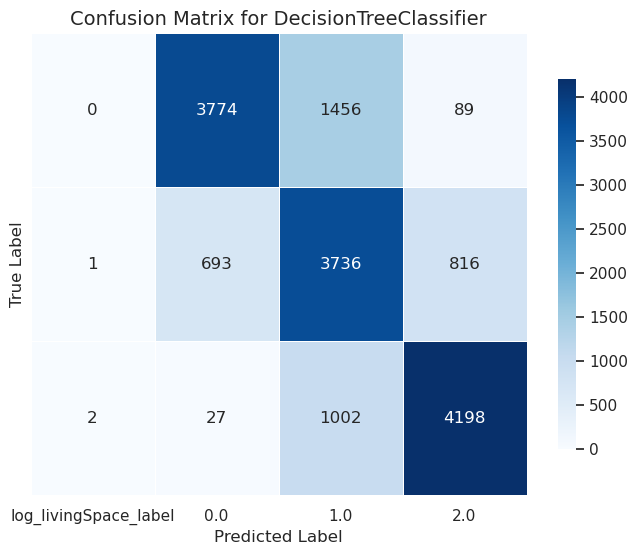

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------

Confusion Matrix for RandomForestClassifier


23/12/15 16:49:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/15 16:49:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/15 16:49:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/15 16:49:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/15 16:49:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/15 16:49:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/15 16:49:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/15 16:49:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/15 16:49:40 WARN RowBasedKeyValueBatch: Calling spill() on

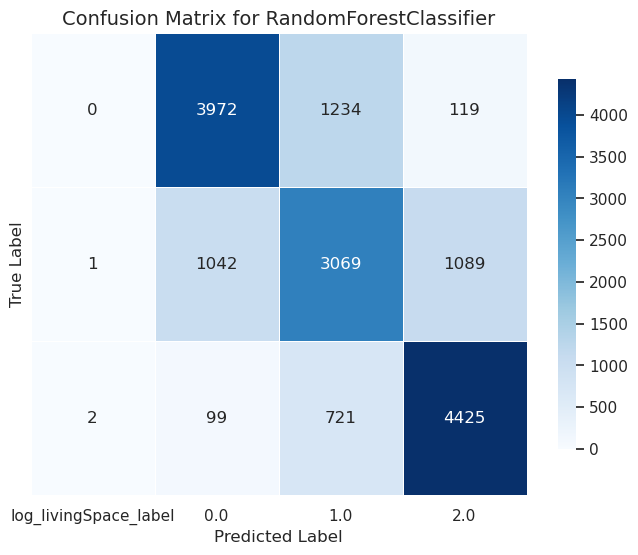

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------

Confusion Matrix for MultilayerPerceptronClassifier


23/12/15 16:50:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/15 16:50:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/15 16:50:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/15 16:50:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/15 16:50:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/15 16:50:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/15 16:50:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/15 16:50:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/15 16:50:47 WARN RowBasedKeyValueBatch: Calling spill() on

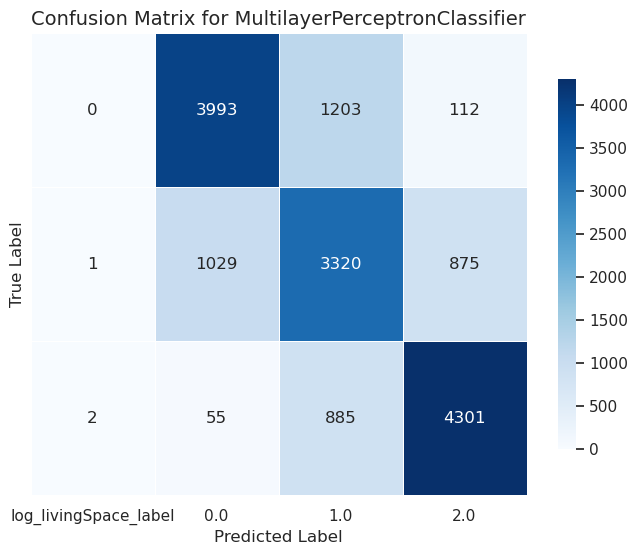

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------



In [174]:
for i,m in enumerate(models_dict):
    print(f"Confusion Matrix for {models_names[i]}")
    conf_mx(models_dict[m][2], target_label, models_names[i])

#### Saving models

In [176]:
#for i,m in models_dict.items():
#    m[0].write().overwrite().save("ddam_project/models/{}_{}".format(models_names[i], target_label.split("_")[0]))